<a href="https://colab.research.google.com/github/vcs512/micro-cnn-model/blob/main/micro_cnn_best_qt_acc92_fpr3_t2_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0- Prepare enviroment

## Create local dir paths for models

In [ ]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
    
MODEL_TF = MODELS_DIR + 'model'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Setup Environment


### Install Dependencies

In [ ]:
# ! pip install tensorflow==2.9.0

### Imports

In [ ]:
# Machine learning library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import plot_model

# Math library
import numpy as np
import math

# Data manipulation library
import pandas as pd

# Graphing and plot library
import matplotlib.pyplot as plt
import seaborn as sns

# Computer vision
import cv2 as cv

### Configure standard seeds and plotting

In [ ]:
# seed for RNG
seed = 2509
np.random.seed(seed)
tf.random.set_seed(seed)

# ploting
plt.rc('legend',fontsize='large')
plt.rc('lines', linewidth=2)
plt.rcParams.update({'axes.facecolor':'white'})

# 1- Training a micro-CNN


The base in this notebook is based in the [hello_world](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world) example for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview).

Builded to run on a ESP32 (TM).

References:

- https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb
- https://www.kaggle.com/code/ginsaputra/visual-inspection-of-casting-products-using-cnn/notebook
- https://www.kaggle.com/code/sfbruno/image-processing-cnn

## Prepare Data for training

### Observing dataset

In [ ]:
# directories of dataset
dir_data = '/content/drive/MyDrive/TCC_VCS/dataset/resize-128'


dir_train = dir_data + '/train'
dir_train_util = dir_train + '/0_utilizavel'
dir_train_def = dir_train + '/1_defeituoso'

dir_test = dir_data + '/test'
dir_test_util = dir_test + '/0_utilizavel'
dir_test_def = dir_test + '/1_defeituoso'

Amostra de utilizável = /content/drive/MyDrive/TCC_VCS/dataset/resize-128/train/0_utilizavel/utiliza (1)
Amostra de defeituosa = /content/drive/MyDrive/TCC_VCS/dataset/resize-128/train/1_defeituoso/defeito (1)


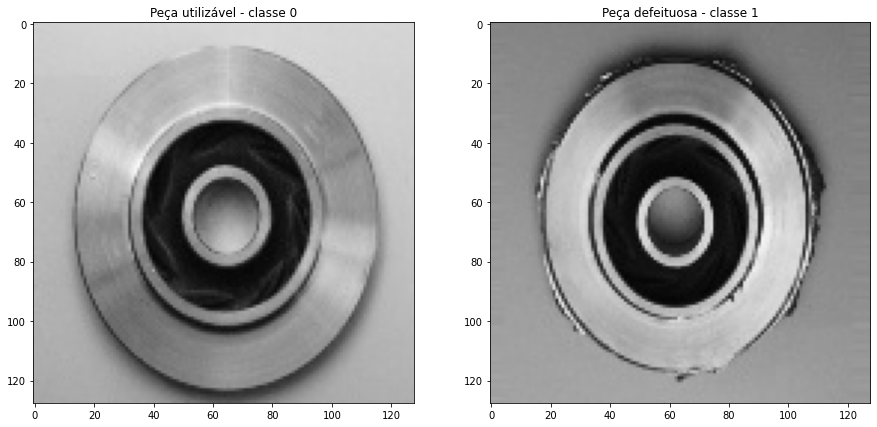

In [ ]:
# see samples
plt.figure(figsize=(15,15))


print('Amostra de utilizável =',dir_train_util+'/utiliza (1)')
plt.subplot(1,2,1)
sample_util = cv.imread(dir_train_util+'/utiliza (1).jpeg')
plt.imshow(sample_util, 'gray')
plt.title('Peça utilizável - classe 0')


print('Amostra de defeituosa =' ,dir_train_def+'/defeito (1)')
plt.subplot(122)
sample_def = cv.imread(dir_train_def+'/defeito (1).jpeg')
plt.imshow(sample_def, 'gray')
plt.title('Peça defeituosa - classe 1')

plt.show()

### Pre-processing function

In [ ]:
# functiond to modify data before training
def pre_func(img):
  
  # img_size = img.shape
  # r = img_size[0]
  # c = img_size[1]

  # # img.reshape(r,c)
  # # # Rotate
  # # rot = np.int8(4*np.random.rand())
  # # if rot>0:
  # #   rot_func = [None, cv.ROTATE_90_CLOCKWISE, cv.ROTATE_180, cv.ROTATE_90_COUNTERCLOCKWISE]
  # #   img = cv.rotate(img, rot_func[rot])
  # # # --debug
  # # # print("rot =", rot)



  # # Zoom
  # zoom = np.int8(5*np.random.rand())
  # # -- debug
  # # print("zoom =", zoom)
  # # zoom = 0
  # zoom = 1 - zoom*0.01
  # # print(zoom)
  # img = img[ np.int8(1+(r*(1-zoom))//2) : np.int8((r*(1+zoom))//2 -1), 
  #            np.int8(1+(c*(1-zoom))//2) : np.int8((c*(1+zoom))//2 -1) ]
  
  # img = img

  # img = cv.resize(img, dsize=(r,c))
  # img = img.reshape(r,c,1)


  return img

/content/drive/MyDrive/TCC_VCS/dataset/resize-128/train/1_defeituoso/defeito (23).jpeg


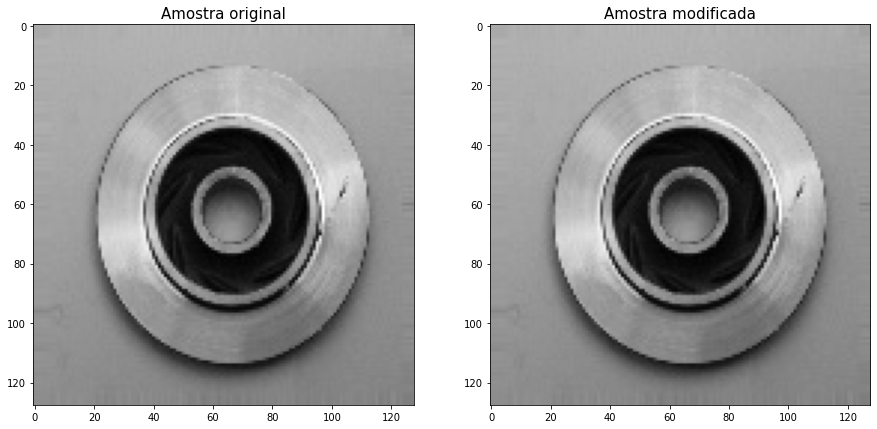

In [ ]:
pre_path = dir_train_def+'/defeito ({}).jpeg'.format(23)
print(pre_path)

pre_test = cv.imread(pre_path, cv.IMREAD_GRAYSCALE)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(pre_test, 'gray')
plt.title('Amostra original', fontsize=15)

pre_test = pre_test.reshape( 128,128,1 )
tmp = pre_func(pre_test).reshape(128,128)
pre_test = tmp

plt.subplot(122)
plt.imshow(pre_test, 'gray')
plt.title('Amostra modificada', fontsize=15)
plt.show()

### Data stream generators

In [ ]:
# common arguments to generators
img_size = sample_util.shape[0:2]
batch_size = 32
rand_seed = 1

In [ ]:
# training
arg_train = {'target_size': img_size,
             'color_mode': 'grayscale',
             'classes': {'0_utilizavel': 0,
                         '1_defeituoso': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}

train_gen = ImageDataGenerator(
                                preprocessing_function=pre_func,
                                # 20% to validation
                                validation_split=0.2)

print('Training set: ')
train_set = train_gen.flow_from_directory(
    directory=dir_train, subset='training', **arg_train)
print(train_set.class_indices)


print('\nValidation set: ')
valid_set = train_gen.flow_from_directory(
    directory=dir_train, subset='validation', **arg_train)
print(valid_set.class_indices)

Training set: 
Found 936 images belonging to 2 classes.
{'0_utilizavel': 0, '1_defeituoso': 1}

Validation set: 
Found 233 images belonging to 2 classes.
{'0_utilizavel': 0, '1_defeituoso': 1}


In [ ]:
# Test
arg_test = {'target_size': img_size,
            'color_mode': 'grayscale',
             'classes': {'0_utilizavel': 0,
                         '1_defeituoso': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}

test_gen = ImageDataGenerator( preprocessing_function=pre_func)

print('Testing set: ')
test_set = test_gen.flow_from_directory(
    directory=dir_test, **arg_test)
print(test_set.class_indices)

Testing set: 
Found 128 images belonging to 2 classes.
{'0_utilizavel': 0, '1_defeituoso': 1}


## Training

### Create a model

In [ ]:
# Define CNN model architecture

# options
k_pool = 2    # pooling kernel size
k_conv = 3    # convolution kernel size

n_filter = 2  # number of filters
reduc = 2     # stride reduction factor


# Modeling
cnn_model = Sequential()
# 128
cnn_model.add( Conv2D(filters=n_filter, kernel_size=(k_conv, k_conv), strides=1, activation='relu', padding='same', input_shape=img_size+(1,)) )
cnn_model.add( AveragePooling2D(pool_size=(k_pool, k_pool), strides=reduc) )

# 64
cnn_model.add( Conv2D(filters=2*n_filter, kernel_size=(k_conv, k_conv), strides=1, activation='relu', padding='same') )
cnn_model.add( AveragePooling2D(pool_size=(k_pool, k_pool), strides=reduc) )

# 32
cnn_model.add( Conv2D(filters=4*n_filter, kernel_size=(k_conv, k_conv), strides=1, activation='relu', padding='same') )
cnn_model.add( AveragePooling2D(pool_size=(k_pool, k_pool), strides=reduc) )
cnn_model.add( Dropout(.05) )

# 16
cnn_model.add( Conv2D(filters=4*n_filter, kernel_size=(k_conv+2, k_conv+2), strides=1, activation='relu', padding='same') )
cnn_model.add( AveragePooling2D(pool_size=(k_pool, k_pool), strides=reduc) )
cnn_model.add( Dropout(.10) )

# 8
cnn_model.add( Conv2D(filters=8*n_filter, kernel_size=(k_conv-2, k_conv-2), strides=1, activation='relu', padding='same') )
cnn_model.add( Dropout(.10) )
cnn_model.add( Conv2D(filters=16*n_filter, kernel_size=(k_conv-2, k_conv-2), strides=1, activation='relu', padding='same') )

#
cnn_model.add( Flatten() )
cnn_model.add( Dense(1, activation='sigmoid') )


# Training parameters
  # Defaults
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),  
    loss='binary_crossentropy',
    metrics=['accuracy'])

# model architecture
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 2)       20        
                                                                 
 average_pooling2d_4 (Averag  (None, 64, 64, 2)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 4)         76        
                                                                 
 average_pooling2d_5 (Averag  (None, 32, 32, 4)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 8)         296       
                                                                 
 average_pooling2d_6 (Averag  (None, 16, 16, 8)       

#### Graphical model

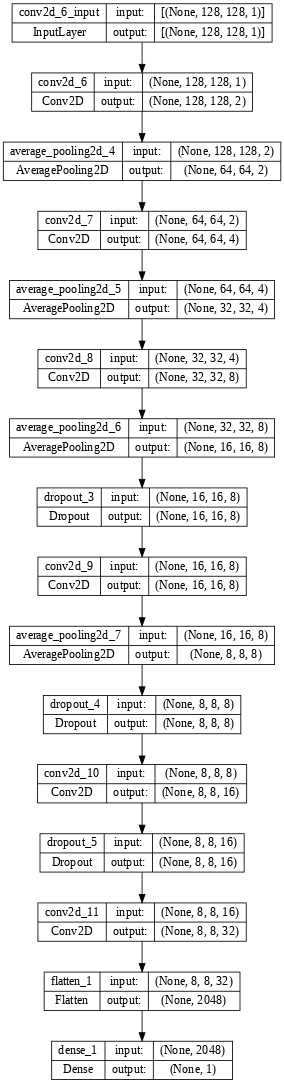

In [ ]:
plot_model(cnn_model, show_shapes=True, expand_nested=True, dpi=60)

### A - Train

In [ ]:
# Fit model using train and validation set
n_epochs = 100

history = cnn_model.fit(
            train_set,
            validation_data=valid_set,

            # training options
            epochs=n_epochs,
            batch_size=32,
            verbose=1,

            # save less validation loss
            callbacks=ModelCheckpoint(
                      'CNN_Casting_Inspection.h5',
                      save_best_only=True,
                      monitor='val_loss')
            )
    
cnn_model.save(MODEL_TF)

Epoch 1/100
30/30 [==============================] - 3s 72ms/step - loss: 2.1950 - accuracy: 0.5363 - val_loss: 0.6818 - val_accuracy: 0.6180
Epoch 2/100
30/30 [==============================] - 2s 66ms/step - loss: 0.6884 - accuracy: 0.6261 - val_loss: 0.6064 - val_accuracy: 0.6567
Epoch 3/100
30/30 [==============================] - 2s 72ms/step - loss: 0.6186 - accuracy: 0.6752 - val_loss: 0.6053 - val_accuracy: 0.6395
Epoch 4/100
30/30 [==============================] - 2s 76ms/step - loss: 0.5992 - accuracy: 0.6966 - val_loss: 0.5941 - val_accuracy: 0.6395
Epoch 5/100
30/30 [==============================] - 2s 67ms/step - loss: 0.5938 - accuracy: 0.6859 - val_loss: 0.5940 - val_accuracy: 0.6524
Epoch 6/100
30/30 [==============================] - 2s 66ms/step - loss: 0.5773 - accuracy: 0.7019 - val_loss: 0.5921 - val_accuracy: 0.6781
Epoch 7/100
30/30 [==============================] - 2s 67ms/step - loss: 0.5682 - accuracy: 0.7201 - val_loss: 0.5899 - val_accuracy: 0.6824
Epoch 

### Train metrics

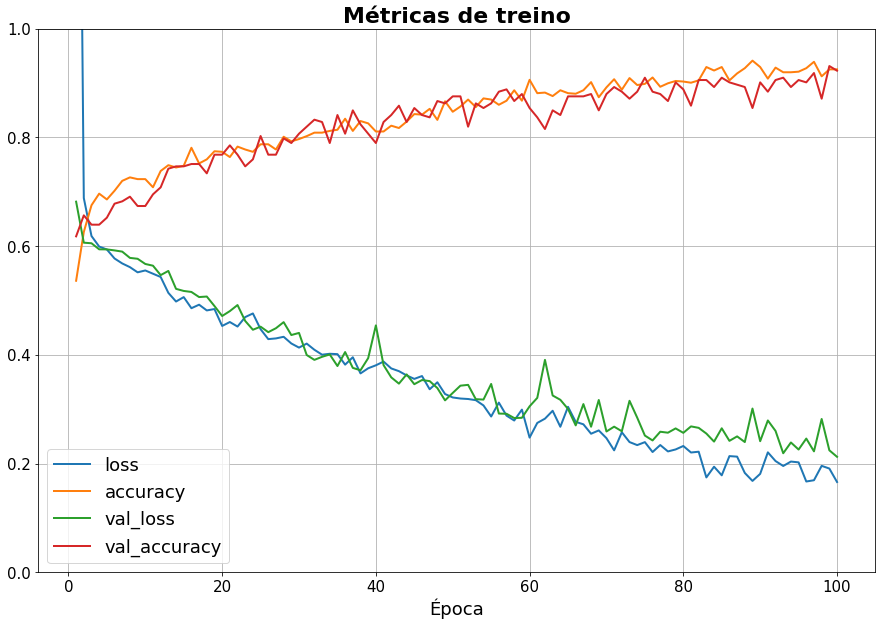

In [ ]:
# Prepare history
histo_dict = cnn_model.history.history
histo_df = pd.DataFrame(histo_dict, index=range(1,n_epochs+1))

# Plot metrics
fig, ax = plt.subplots(figsize=(15,10))
for m in histo_df.columns:
    ax.plot(histo_df.index, m, data=histo_df)

ax.set_xlabel('Época', fontsize=18)
ax.set_title('Métricas de treino', weight='bold', fontsize=22)
ax.legend(fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()
plt.ylim([0,1])
plt.show()

### Test metrics

#### Apply test set

In [ ]:
best_model = load_model('./CNN_Casting_Inspection.h5')

# inference in test set
y_pred_prob = best_model.predict(test_set, verbose=1)
y_pred = (y_pred_prob >= 0.5).reshape(-1,)
y_true = test_set.classes[test_set.index_array]


4/4 [==============================] - 0s 55ms/step


#### B - ACC and FPR

In [ ]:
# ACCURACY
                                 #( where diference exists        )
accuracy = 1 -  ( np.count_nonzero(np.int8(y_true)-np.int8(y_pred))  / len(y_pred) )
accuracy = accuracy*100
print('Accuracy = ', accuracy, '%' )


# FALSE POSITIVE RATE
coded = np.int8(y_true)-np.int8(y_pred)
#  * 0  : OK
#  * -1 : ok tagged as defect
#  ** 1 : defect not spotted
  # print(np.int8(y_true)-np.int8(y_pred))

defeituosas = np.count_nonzero(np.int8(y_true))
print('\nTotal Defective number = ', defeituosas)

false_positive = np.count_nonzero( coded==1 )
fpr = 100* (false_positive / defeituosas)
print('False Positive Rate = ', fpr, '%')

# see false positives
inicia_defeitos = 704
class_0_test = np.count_nonzero( np.int8(y_true)==0 ) # find total usable
offset = inicia_defeitos-class_0_test # jump to test numeration, not include usable
# aware of OFFSET:
false_p_id = np.argwhere( coded==1 ).reshape(1,false_positive) + offset
false_p_id = false_p_id[0]
print('False positives ID =', false_p_id) 

Accuracy =  94.53125 %

Total Defective number =  77
False Positive Rate =  3.896103896103896 %
False positives ID = [720 767 769]


#### See false positives 

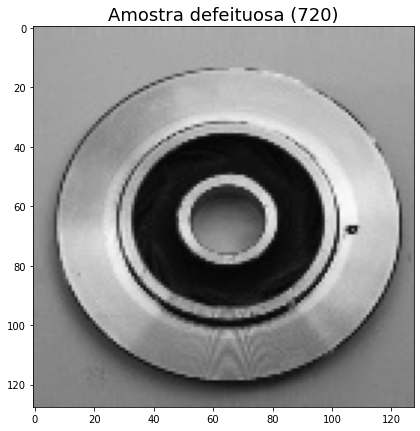

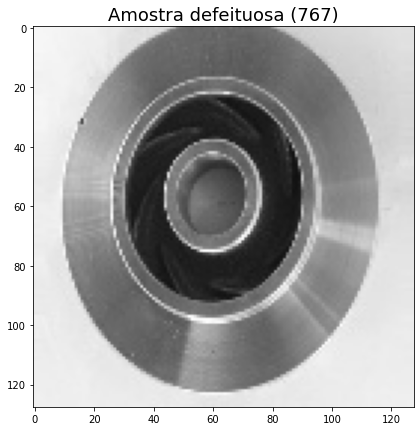

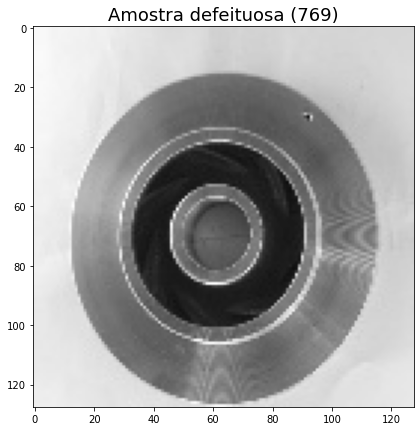

In [ ]:
for errada in false_p_id:
  plt.figure(figsize=(7,7))
  false_p = cv.imread(dir_test_def+'/defeito ({}).jpeg'.format(errada))
  plt.title("Amostra defeituosa ({})".format(errada), fontsize=18)
  plt.imshow(false_p, 'gray')

#### Confusion Matrix

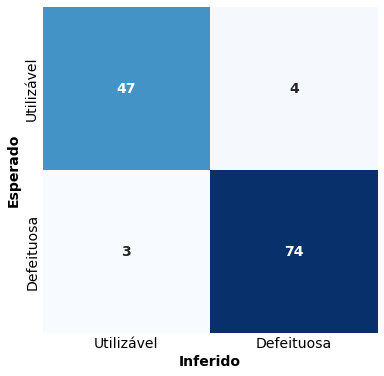

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(confusion_matrix(y_true,y_pred), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Blues')

ax.set_xticklabels(['Utilizável', 'Defeituosa'])
ax.set_yticklabels(['Utilizável', 'Defeituosa'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Esperado', size=14, weight='bold')
plt.xlabel('Inferido', size=14, weight='bold')
plt.show()

# Look at left down

## Quantization in int8

In [ ]:
# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  # for i in range(2):
  #   if i == 0:
  #     yield([ np.float32(np.zeros( (128,128) ).reshape(-1, *img_size , 1))])
  #   if i == 1:
  #     yield([ np.float32(255*np.ones( (128,128) ).reshape(-1, *img_size , 1)) ] )
  
  for path in train_set.filepaths:
    tmp = np.float32(cv.imread(path, cv.IMREAD_GRAYSCALE) )
    # tmp = pre_func(tmp)
    yield([ tmp.reshape(-1, *img_size , 1)])


converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
# converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Type of input/output
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Provide a representative dataset for quantization
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)


interpreter = tf.lite.Interpreter(model_content=model_tflite)
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print('\n', input_details)
print(output_details)


 {'name': 'serving_default_conv2d_6_input:0', 'index': 0, 'shape': array([  1, 128, 128,   1], dtype=int32), 'shape_signature': array([ -1, 128, 128,   1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, -128), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 28, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


### Compare Model Performance

In [ ]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  x_test_ = x_test_
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # Quantize the input layer
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  
  # Invoke the interpreter
  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
  
  # Dequantize the output layer
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

#### C - New accuracy and FPR

In [ ]:
qt_y_pred = list()
qt_y_pred_prob = list()

# Calculate predictions for test set
for path in test_set.filepaths:
  img = cv.imread(path, cv.IMREAD_GRAYSCALE).reshape(-1, *img_size, 1)

  qt_y_pred_prob.append( predict_tflite(model_tflite, img)[0] )
  qt_y_pred_tmp = (qt_y_pred_prob[-1] >= 0.5).reshape(-1,)
  qt_y_pred.append( qt_y_pred_tmp )

qt_y_pred = np.array(qt_y_pred)

# ground truth
y_true = test_set.classes[test_set.index_array].reshape(len(y_true),1)

In [ ]:
# ACCURACY
                                    #( where diference exists          )
qt_accuracy = 1 -  ( np.count_nonzero(np.int8(y_true)-np.int8(qt_y_pred))  / len(qt_y_pred) )
qt_accuracy = qt_accuracy*100
print('Quantized accuracy = ', qt_accuracy, '%' )


# FALSE POSITIVE RATE
qt_coded = (np.int8(y_true)-np.int8(qt_y_pred))
qt_coded = qt_coded.reshape(-1,)
#  * 0  : OK
#  * -1 : ok tagged as defect
#  ** 1 : defect not spotted
  # print(np.int8(y_true)-np.int8(y_pred))

qt_defeituosas = np.count_nonzero(np.int8(y_true))
print('\nTotal Defective number = ', defeituosas)

qt_false_positive = np.count_nonzero( qt_coded==1 )
qt_fpr = 100* (qt_false_positive / qt_defeituosas)
print('False Positive Rate = ', qt_fpr, '%')

# see false positives
inicia_defeitos = 704
class_0_test = np.count_nonzero( np.int8(y_true)==0 ) # find total usable
offset = inicia_defeitos-class_0_test # jump to test numeration, not include usable
# aware of OFFSET:
qt_false_p_id = np.argwhere( qt_coded==1 ).reshape(1,qt_false_positive) + offset
qt_false_p_id = qt_false_p_id[0]
print('False positives ID =', qt_false_p_id) 

Quantized accuracy =  92.96875 %

Total Defective number =  77
False Positive Rate =  3.896103896103896 %
False positives ID = [720 767 769]


#### See false positives 

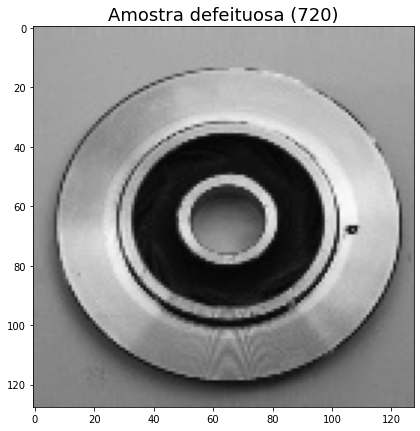

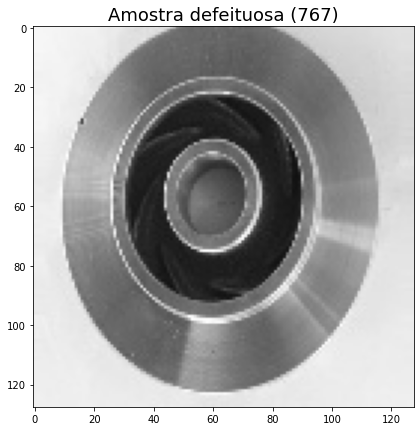

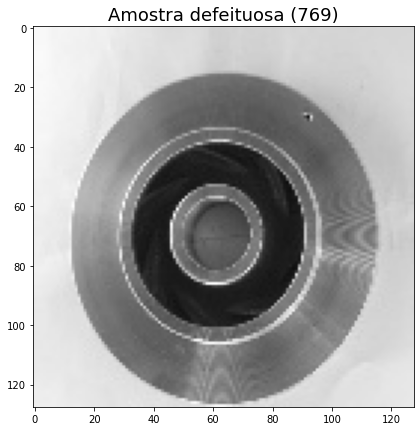

In [ ]:
for errada in qt_false_p_id:
  plt.figure(figsize=(7,7))
  false_p = cv.imread(dir_test_def+'/defeito ({}).jpeg'.format(errada))
  plt.title("Amostra defeituosa ({})".format(errada), fontsize=18)
  plt.imshow(false_p, 'gray')

#### Confusion Matrix

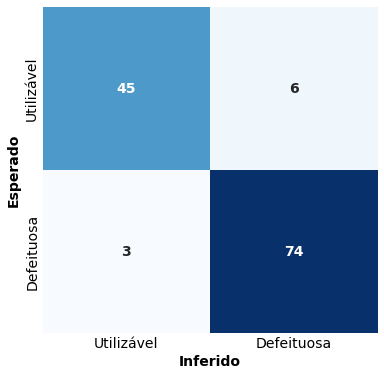

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.heatmap(confusion_matrix(y_true,qt_y_pred), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Blues')

ax.set_xticklabels(['Utilizável', 'Defeituosa'])
ax.set_yticklabels(['Utilizável', 'Defeituosa'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Esperado', size=14, weight='bold')
plt.xlabel('Inferido', size=14, weight='bold')
plt.show()

# Look at left down

#### D - PoC

In [ ]:
# Calculate predictions

y_test_pred_tf = list()
y_test_pred_no_quant_tflite = list()
y_test_pred_tflite = list()


# PoC for class 0
test = 468 # begin of utils in test
fator = 4
for i in range(test,test+5):
  # DEBUGG and PoC
  # if i == test+4:
  #   img = 50*np.ones( (512//fator,512//fator) ).reshape(-1, *img_size, 1)
  #   # img = np.zeros( (512//fator,512//fator) ).reshape(-1, *img_size, 1)

  # test set
  path = dir_test_util + '/utiliza ({}).jpeg'.format(i)
  img = cv.imread(path, cv.IMREAD_GRAYSCALE).reshape(-1, *img_size, 1)

  y_test_pred_tf.append(cnn_model.predict(img))
  y_test_pred_tflite.append( predict_tflite(model_tflite, img) )

# PoC for class 1
test = 704 # begin of defectives in test
fator = 4
for i in range(test,test+5):
  # DEBUGG and PoC
  # if i == test+4:
  #   img = 50*np.ones( (512//fator,512//fator) ).reshape(-1, *img_size, 1)
  #   # img = np.zeros( (512//fator,512//fator) ).reshape(-1, *img_size, 1)

  # test set
  path = dir_test_def + '/defeito ({}).jpeg'.format(i)
  img = cv.imread(path, cv.IMREAD_GRAYSCALE).reshape(-1, *img_size, 1)

  y_test_pred_tf.append(cnn_model.predict(img))
  y_test_pred_tflite.append( predict_tflite(model_tflite, img) )

1/1 [==============================] - 0s 15ms/step


In [ ]:
# Compare predictions
for i in range(len(y_test_pred_tf)):
  
  if i==0:
    print('== Utilizables ==')
  if i==5:
    print('== Defectives ==')

  print('Image number', i)
  
  print('float model output =', 100*y_test_pred_tf[i][0][0])
  print('quantized model output', 100*y_test_pred_tflite[i][0])
  print('\n')

== Utilizables ==
Image number 0
float model output = 8.747965842485428
quantized model output 7.421875


Image number 1
float model output = 11.132903397083282
quantized model output 8.203125


Image number 2
float model output = 1.5935534611344337
quantized model output 1.5625


Image number 3
float model output = 5.273831635713577
quantized model output 5.46875


Image number 4
float model output = 2.6231447234749794
quantized model output 3.125


== Defectives ==
Image number 5
float model output = 77.34603881835938
quantized model output 78.90625


Image number 6
float model output = 99.02747869491577
quantized model output 99.21875


Image number 7
float model output = 71.98525071144104
quantized model output 75.0


Image number 8
float model output = 94.17211413383484
quantized model output 95.3125


Image number 9
float model output = 99.99825954437256
quantized model output 99.609375




#### Quantization effect

In [ ]:
qt_y_pred_prob = np.array(qt_y_pred_prob).reshape(len(qt_y_pred_prob),1)


differences = np.abs(qt_y_pred_prob - y_pred_prob)

media = np.mean(differences)
print("Mean difference = ", media)


print("Maximum difference = ", np.max(differences))
desvio = np.std(differences, ddof=1)
print("Standard deviation = ", desvio)
print("Number of samples above 3 std dev = ", (differences>(media+3*desvio)).sum() )

Mean difference =  0.009967536
Maximum difference =  0.06361246
Standard deviation =  0.013294696
Number of samples above 3 std dev =  5


# Generate a TFLite Micro Model in C
Convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite Micro.

In [ ]:
# Install xxd
!apt-get update && apt-get -qq install xxd

# Convert to a C source file
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}

# Update variable names to be C compatible
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main

## C model for Microcontroller

Follow the instructions in the [hello_world](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world) README.md for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview) to deploy this model on a specific microcontroller.

ESP32 references: https://github.com/espressif/tflite-micro-esp-examples/tree/master/examples/person_detection

In [ ]:
# Print the C source file
# !cat {MODEL_TFLITE_MICRO}